In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import sys
import os

In [357]:
module_path = os.path.abspath(os.path.join('..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path

from ipynb_func import *

In [358]:
'''
We're working with a little processed data. At this notebook we'll process it for tagging/classification task. 
'''
NUM = 1 # Number of data parquets to use

assert NUM >= 1 and NUM <= 9, "NUM value must be in range [1, 9]"
paths = [module_path + f"/data/pikabu/processed/{i}_processed.parquet" for i in range(NUM)] # Making list of roots to merge 

data = merge_dataset(paths)

In [359]:
data = data[data['text_markdown'] != ''] # delete posts without text inside
data = data[['text_markdown', 'tags']] # taking the most interesting parts for our task
data.head(5)

,text_markdown,tags
0,осень россия стартовать продажа очередной моде...,Китай;AliExpress;Китайские товары;Бизнес;Длинн...
1,канун освобождение концлагерь v всемирный фору...,Великая Отечественная война;Чтобы помнили;Осве...
2,честь сочинять свой первый пирожок приходить з...,Стишки-Пирожки;Снег;Тюмень;Мат
4,общий кратце заказывать как-то новый год доста...,Delivery Club;Доставка еды;Пицца;Длиннопост
6,art by svetlana nurkaeva,WOW;World of Warcraft;Арт;Эльфы;Ночные эльфы


In [360]:
bad_tags = ['Фотография', 'Видео', 'Скриншот', 'Anime Art', 'Гифка', 'Арт', 'Рисунок'] # as we decided at tag_analysis
tags_to_remove = ['Длиннопост', 'Текст', 'Без рейтинга', 'Ответ на пост', 'Комментарии'] # not problematic, but tags, that are not in our interests

data = removePostByTags(data, bad_tags)
data.tags = removeTags(data, tags_to_remove)
data.tags = formateTags(data)

data.head(5)

,text_markdown,tags
0,осень россия стартовать продажа очередной моде...,"[Китай, AliExpress, Китайские товары, Бизнес]"
1,канун освобождение концлагерь v всемирный фору...,"[Великая Отечественная война, Чтобы помнили, О..."
2,честь сочинять свой первый пирожок приходить з...,"[Стишки-Пирожки, Снег, Тюмень, Мат]"
4,общий кратце заказывать как-то новый год доста...,"[Delivery Club, Доставка еды, Пицца]"
7,аня волос нос расти петя аня мочь жопа рассада...,"[Петр, Анна, Рассада, Волосы, Переписка, Знако..."


In [361]:
total_words = ''.join(data.text_markdown)
total_words = re.split(r' ', total_words)
words_dict = getworddict(total_words)

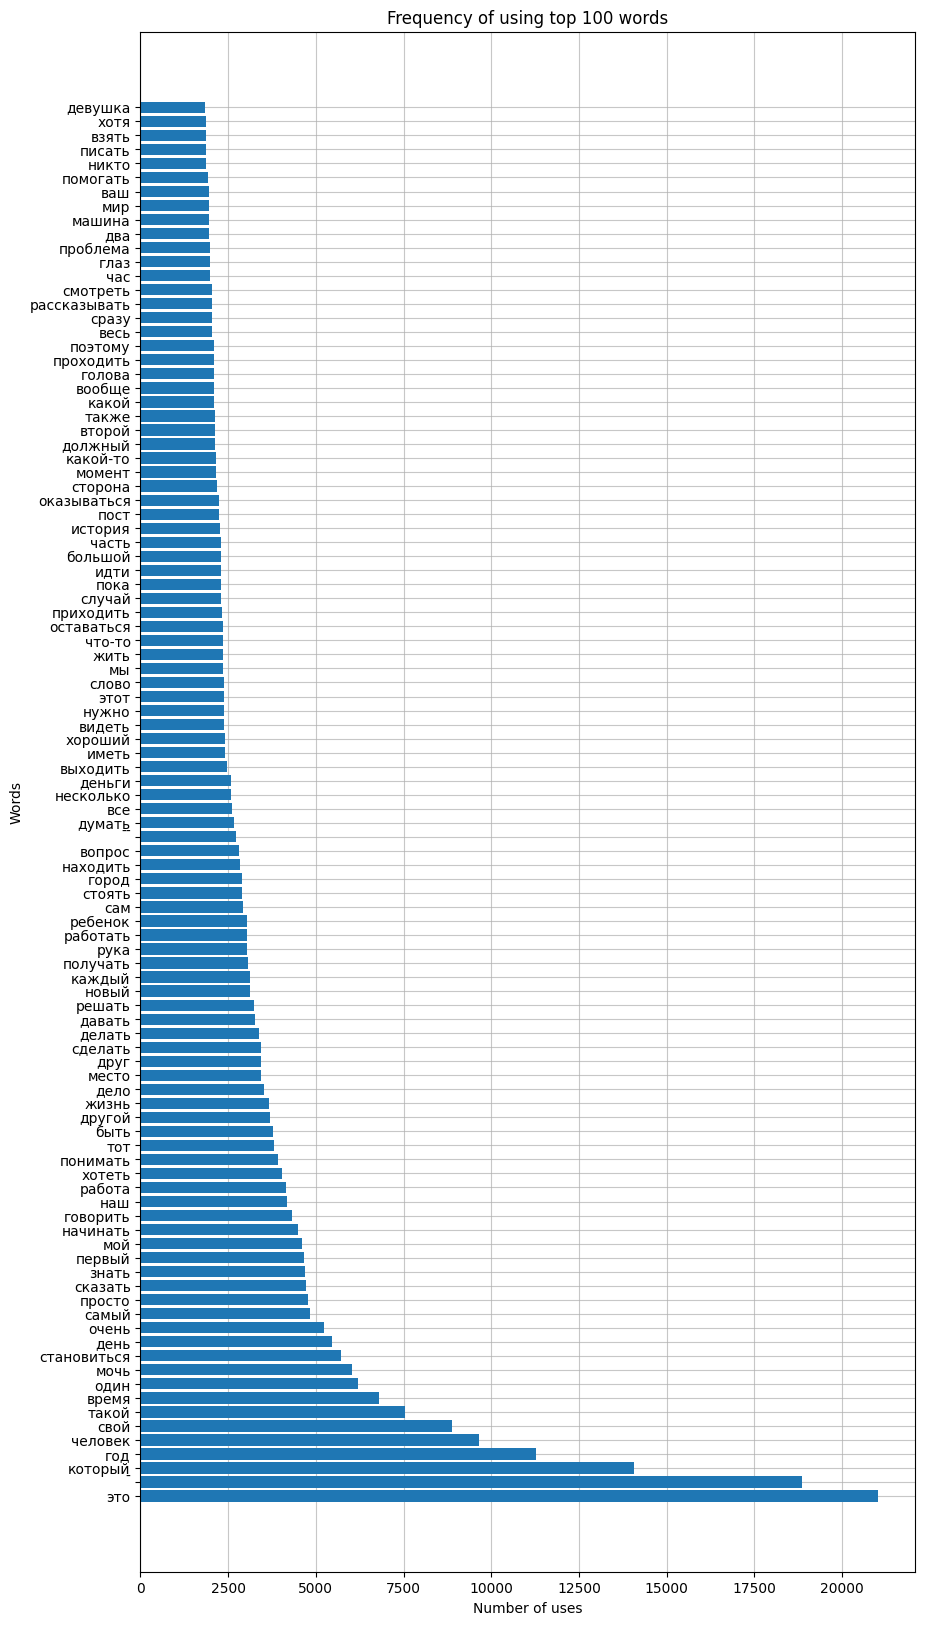

In [362]:
NUM_WORDS = 100
fig, ax = plt.subplots(figsize=(10,20))

word = list(words_dict.keys())
count = list(words_dict.values())

ax.grid(zorder=1, alpha=0.7)
ax.barh(word[0:NUM_WORDS], count[0:NUM_WORDS], zorder=2)
ax.set_title(f"Frequency of using top {NUM_WORDS} words")
ax.set_xlabel("Number of uses")
ax.set_ylabel("Words");

In [363]:
#Additional clear for stopwords
txt_root = module_path + '/scripts/stopwords-ru.txt' # github.com/stopwords-iso/stopwords-ru
with open(txt_root, encoding="utf-8") as f:
    rustopwords = f.readlines()
    rustopwords = [word.strip() for word in rustopwords]

additional_stopwords = ['https', '--', '-\n','--\n', '-', 'становиться', 'решать', 'начинать']

final_stopwords = additional_stopwords + rustopwords

In [364]:
#TF-IDF filtering.

IDF_LEFT_RANGE = 3.
IDF_RIGHT_RANGE = 7.

text_for_idf = [''.join(txt) for txt in data.text_markdown]

tf_idf = TfidfVectorizer(smooth_idf=False)
tf_idf.fit(text_for_idf)
idfs = tf_idf.idf_

idf_mask = (idfs > IDF_LEFT_RANGE) * (idfs < IDF_RIGHT_RANGE)
permitted_words = tf_idf.get_feature_names_out()[idf_mask].tolist()

In [365]:
#final processing of a text
raw_text = [t for t in data.text_markdown]
raw_text = [re.split(r' ', sentance) for sentance in raw_text]
processed_text = [[t for t in words if (t not in final_stopwords) and (t in permitted_words)] for words in raw_text]

data.text_markdown = processed_text # data without stopwords

In [366]:
processed_dct = []
for i in range(len(processed_text)):
    processed_dct.extend(processed_text[i])

processed_dct = getworddict(processed_dct)

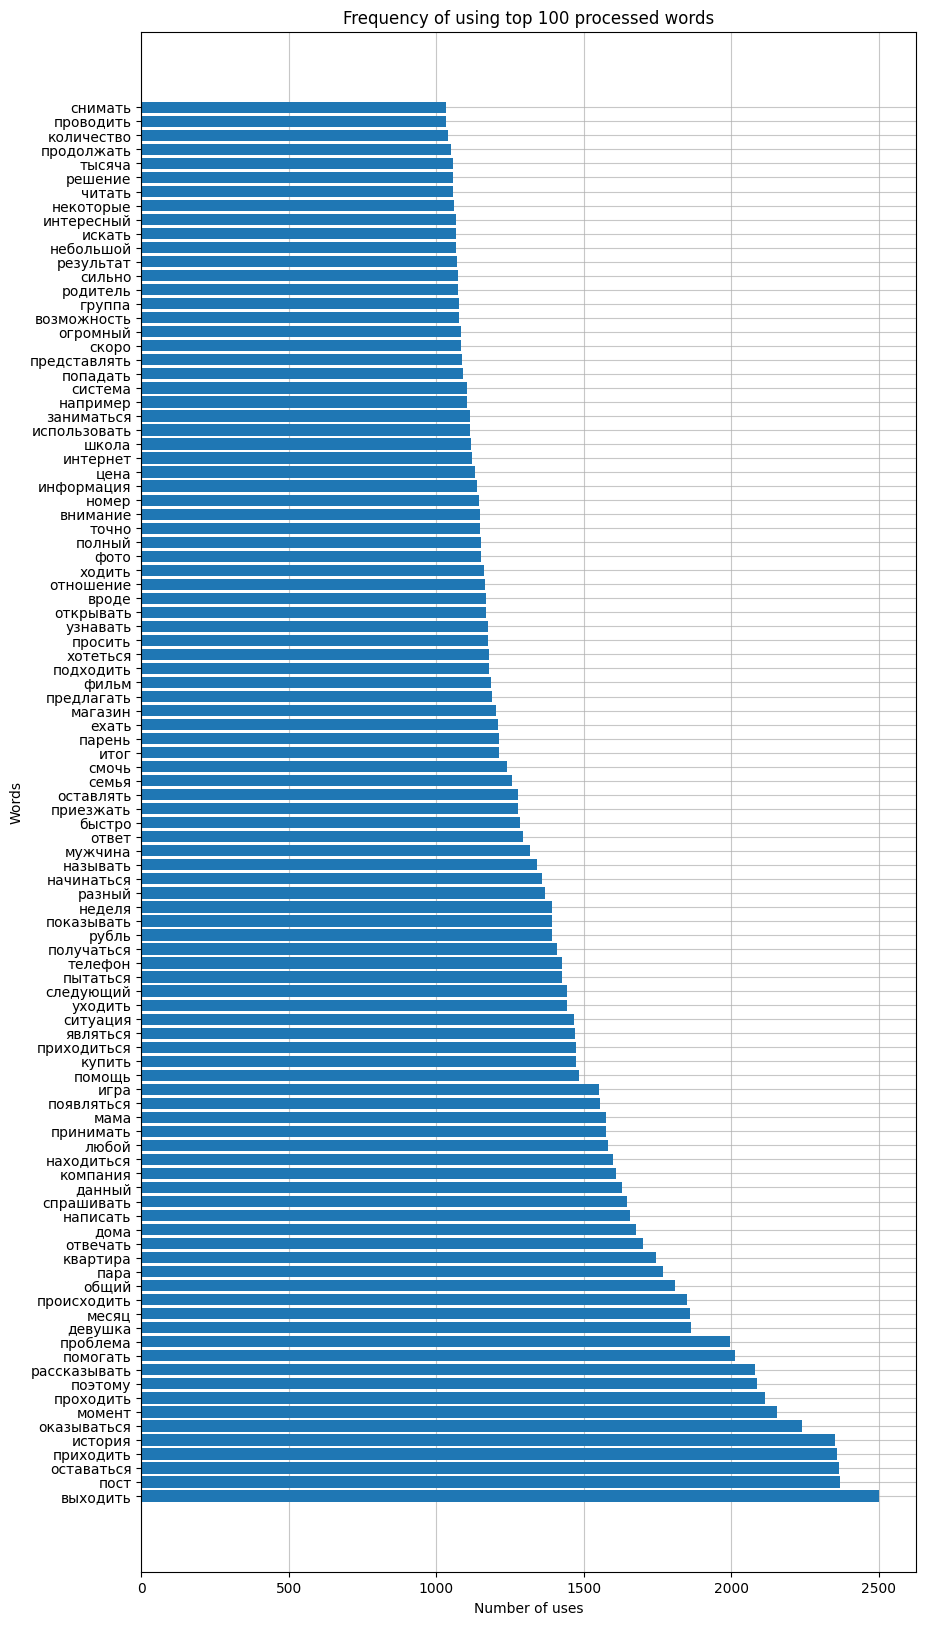

In [367]:
fig, ax = plt.subplots(figsize=(10,20))

word = list(processed_dct.keys())
count = list(processed_dct.values())

ax.grid(zorder=1, alpha=0.7)
ax.barh(word[0:NUM_WORDS], count[0:NUM_WORDS], zorder=2)
ax.set_title(f"Frequency of using top {NUM_WORDS} processed words")
ax.set_xlabel("Number of uses")
ax.set_ylabel("Words");

In [368]:
'''
Taking posts with more than NUM_OF_WORDS_IN_POST value.
'''
NUM_OF_WORDS_IN_POST = 100

text = [texts for texts in data['text_markdown']]
mask = [len(texts) > NUM_OF_WORDS_IN_POST for texts in text]

new_data = data
new_data = new_data[mask]

new_data.head(5)

,text_markdown,tags
0,"[осень, стартовать, продажа, очередной, модель...","[Китай, AliExpress, Китайские товары, Бизнес]"
1,"[освобождение, всемирный, форум, память, ветер...","[Великая Отечественная война, Чтобы помнили, О..."
10,"[вспоминать, успешный, операция, британский, м...","[История, Флот, Война, Вторая мировая война, В..."
41,"[яблоко, проклятие, вспоминать, прошлый, век, ...","[Яблоки, Мат, Джем, Рецепт]"
42,"[проходить, пятница, район, подмосковье, откры...","[Сортировка, Переработка мусора, Бактерии, Ком..."


In [370]:
save_path = module_path + '/data/pikabu/tag_processed/'
new_data.to_parquet(save_path + '0_tag_processed.parquet')